# Modeling

In [140]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from itertools import product
from collections import defaultdict
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import sys
sys.path.append("../model")
from new_model import get_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read data

In [225]:
df = get_data()

In [228]:
df.sort_values(by="pickup", inplace=True)

In [230]:
def get_datetime(series):
    return pd.to_datetime('1899-12-30') + pd.to_timedelta(series, 'D')

df["pickup"] = get_datetime(df["pickup"])
df["dropoff"] = get_datetime(df["dropoff"])
df["created_at"] = get_datetime(df["created_at"])
df["updated_at"] = get_datetime(df["updated_at"])

In [231]:
df["pickup_dow"] = df["pickup"].dt.dayofweek
df["pickup_month"] = df["pickup"].dt.month
df["pickup_year"] = df["pickup"].dt.year
df["time_to_pickup"] = (df["pickup"] - df["created_at"]).dt.total_seconds() / 86400
df["trip_duration"] = (df["dropoff"] - df["pickup"]).dt.total_seconds() / 86400
df["modified"] = (df["updated_at"].dt.date > df["created_at"].dt.date).astype(int)
df["modified_time"] = (df["updated_at"] - df["created_at"]).dt.total_seconds() / 86400

In [232]:
df["cancelled"] = ((df["current_state"] != "finished") & (df["current_state"] != "started")).astype(int)
df["used_promo"] = (df["promo_code_id"].notnull()).astype(int)
df["web_booking"] = (df["booking_application"].isin(["web", "web-desktop", "web-mobile", "web-tablet"])).astype(int)

In [233]:
df["weekend_pickup"] = (df["pickup_dow"].isin([4, 5, 6])).astype(int)
df["winter_pickup"] = (df["pickup_dow"].isin([1, 12])).astype(int)
df["new_customer"] = (df["reservation_frequency"] != "repeat_customer").astype(int)

In [234]:
d = defaultdict(list)
lst = []
for i, user_id in enumerate(df["user_id"]):
    lst.append(d[user_id].copy())
    d[user_id].append(df["cancelled"].iloc[i])
df["num_rides"] = lst

In [235]:
df["previous_rides"] = df["num_rides"].apply(lambda lst: len(lst))
df["previous_cancellations"] = df["num_rides"].apply(lambda lst: sum(lst))
df["previous_percent_cancelled"] = df["previous_cancellations"] / df["previous_rides"]
df["previous_percent_cancelled"] = df["previous_percent_cancelled"].fillna(df["cancelled"].mean())

In [236]:
df["used_referral"] = (~df["referral_code"].isnull()).astype(int)
df["credit_card"] = (df["postal_code"].notnull()).astype(int)
df["western_pickup"] = ((df["time_zone"] == "pst") | (df["time_zone"] == "mst")).astype(int)

In [237]:
df.fillna(value={"is_corporate": 0, "is_silvercar": 0, "is_personal": 0, "is_gds_user": 0}, inplace=True)

,id,user_id,pickup_location_id,current_state,created_as_guest,local_rental,awards_referral_bonus,pickup,dropoff,created_at,...,weekend_pickup,winter_pickup,new_customer,num_rides,previous_rides,previous_cancellations,previous_percent_cancelled,used_referral,credit_card,western_pickup
0,89,12,1,cancelled,0,0,0,2013-01-14 07:00:00.288,2013-01-15 09:29:59.712,2012-12-26 19:31:35.904000000,...,0,0,1,[],0,0,0.411226,1,1,0
88,192,10,1,cancelled,0,0,0,2013-01-14 10:30:00.000,2013-01-14 13:30:00.000,2013-01-13 22:09:28.800000000,...,0,0,1,[],0,0,0.411226,1,1,0
24,118,145,1,cancelled,0,0,0,2013-01-14 13:30:00.000,2013-01-17 21:00:00.000,2012-12-28 16:23:09.600000000,...,0,0,1,[],0,0,0.411226,1,0,0
11,103,12,1,cancelled,0,0,0,2013-01-14 15:29:59.712,2013-01-15 15:00:00.000,2012-12-27 03:34:50.880000000,...,0,0,1,[1],1,1,1.000000,1,1,0
66,165,255,1,finished,0,0,0,2013-01-14 16:00:00.288,2013-01-17 16:00:00.288,2013-01-09 22:05:21.696000000,...,0,0,1,[],0,0,0.411226,1,1,0
79,183,52,1,finished,0,0,0,2013-01-14 16:00:00.288,2013-01-16 19:00:00.288,2013-01-12 20:55:02.784000000,...,0,0,1,[],0,0,0.411226,1,1,0
77,181,313,1,finished,0,0,0,2013-01-14 16:00:00.288,2013-01-18 16:00:00.288,2013-01-11 22:57:50.976000000,...,0,0,1,[],0,0,0.411226,1,1,0
46,141,6,1,cancelled,0,0,0,2013-01-14 16:30:00.000,2013-01-17 16:30:00.000,2013-01-04 03:12:12.671999999,...,0,0,1,[],0,0,0.411226,1,1,0
90,194,170,1,cancelled,0,0,0,2013-01-14 16:30:00.000,2013-01-15 11:30:00.288,2013-01-14 15:49:38.208000000,...,0,0,1,[],0,0,0.411226,1,1,0
31,126,52,1,cancelled,0,0,0,2013-01-14 16:59:59.712,2013-01-17 22:00:00.288,2012-12-30 18:33:46.080000000,...,0,0,1,[0],1,0,0.000000,1,1,0


In [238]:
df.drop(["id", "user_id", "pickup_location_id", "current_state", "pickup", "dropoff", "created_at", "updated_at",
         "promo_code_id", "booking_application", "reservation_frequency", "num_rides","postal_code", "time_zone",
         "referral_code", "pickup_dow", "pickup_month", "pickup_year"], axis=1, inplace=True)

In [239]:
df.shape

(456387, 23)

In [241]:
np.sum(df.isnull())

created_as_guest              0
local_rental                  0
awards_referral_bonus         0
is_gds_user                   0
is_corporate                  0
is_personal                   0
is_silvercar                  0
time_to_pickup                0
trip_duration                 0
modified                      0
modified_time                 0
cancelled                     0
used_promo                    0
web_booking                   0
weekend_pickup                0
winter_pickup                 0
new_customer                  0
previous_rides                0
previous_cancellations        0
previous_percent_cancelled    0
used_referral                 0
credit_card                   0
western_pickup                0
dtype: int64

In [242]:
y = df.pop("cancelled")
X_train, X_test, y_train, y_test = train_test_split(df, y)

In [243]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [244]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Accuracy: {}".format(lr.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

Accuracy: 0.8889015486822616
Precision: 0.9740284777878763
Recall: 0.7508864307097816


In [245]:
# taken from churn case study solution
def plot_feature_importances(df, feature_importances):
    feat_scores = pd.DataFrame({'Mean Decrease Impurity' : feature_importances},
                           index=df.columns)
    feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
    feat_scores.plot(kind='barh', figsize=(8,8))

In [246]:
# stolen from sklearn's example
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks(np.arange(2), ["Finished", "Cancelled"], rotation=45)
    plt.yticks(np.arange(2), ["Finished", "Cancelled"])
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

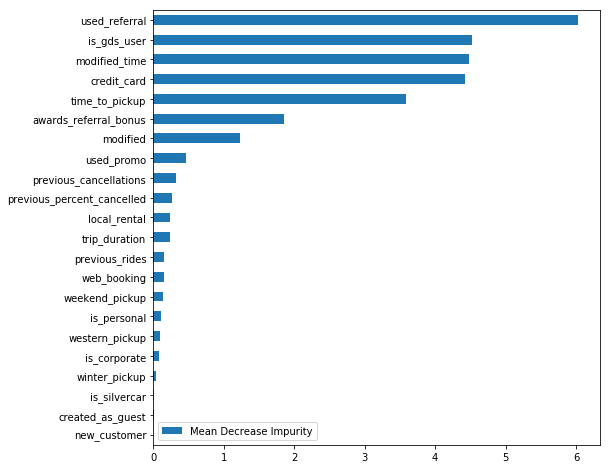

In [247]:
plot_feature_importances(df, np.abs(lr.coef_[0]))

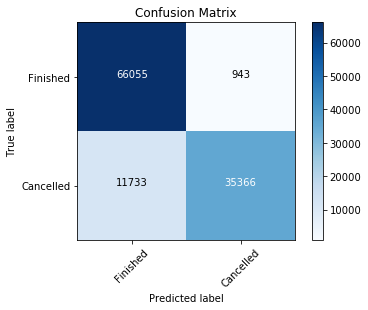

In [ ]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print("Accuracy: {}".format(rf.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, predictions)))
print("Recall: {}".format(recall_score(y_test, predictions)))

In [ ]:
plot_feature_importances(df, rf.feature_importances_)

In [ ]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [1097]:
gbc = GradientBoostingClassifier(n_estimators=20, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [1098]:
gbc.score(X_test, y_test)

0.90986262768580484

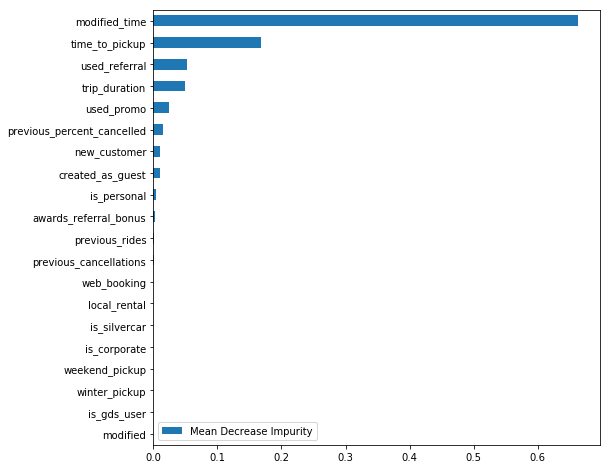

In [1099]:
plot_feature_importances(df_model, gbc.feature_importances_)

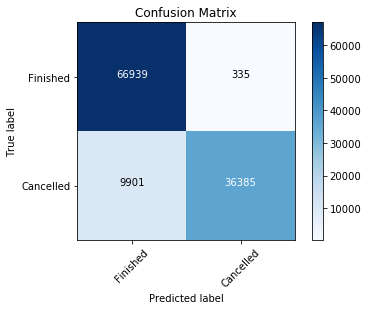

In [1100]:
predictions = gbc.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)